Построить графики распределения в спам и не спам множествах следующих признаков:

1	Количество слов на странице

2	Средняя длинна слова

3	Количество слов в заголовке страниц (слова в теге <html><head><title> Some text </title>)
    
4	Количество слов в анкорах ссылок (<html><body><a> Some text </a>)
    
5	Коэффициент сжатия
    
6   Количество видео на странице
    
7   Количество картинок и банеров на странице

Нужно посчитать статистику минимум по трем признакам и обязательно сделать для 1-го и 2-го признаков

И отправить первое решение в соревнование https://kaggle.com/join/antispam_infopoisk
На основании одного из указанных выше признаков попытаться разделить мн-во, так чтобы score в соревновании был больше 0.55

При выполнении всех этих условия в течении семинара +1 балл к ДЗ

Описание ДЗ и правил выставления за него баллов в https://inclass.kaggle.com/c/antispam-infopoisk  
Сроки ДЗ уточнить у преподователя - обычно 2 недели

In [1]:
from __future__ import division

import base64
import csv
import gzip
import zlib
import functools 
import operator 
import pickle
import pymorphy2
import re

from collections import namedtuple
import xgboost as xgb
from bs4 import BeautifulSoup
from multiprocessing import Pool, Lock, Value
from functools import wraps, reduce
from scipy.stats import randint as sp_randint
import numpy as np

from nltk.corpus import stopwords as nltk_stopwords
from pymystem3 import Mystem
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier


%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
TRACE_NUM = 100
import logging
# reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))
        
mutex = Lock()
n_processed = Value('i', 0)

def logger(func):
    @wraps(func)
    def wrapper(*args, **kwds):
        res = func(*args, **kwds)
        with mutex:
            global n_processed
            n_processed.value += 1
            if n_processed.value % 10 == 0:
                print(f"\r{n_processed.value} pages are processed...",
                      end='', flush=True)
        return res
    return wrapper


### Утилиты

#### Декораторы

In [3]:
def to_utf8(text):
    if isinstance(text, str): text = text.encode('utf-8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, str): text = text.decode('utf-8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

In [4]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [5]:
html2text = html2text_bs
# html2text = html2text_parser

#### Методы для токенизации текста

In [6]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [7]:
def html2word(raw_html, to_text=html2text, tokenizer=pymorphy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

In [8]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print('threshold %s' % threshold)
            print( '\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print( '\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print( '\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [9]:
def html2text_bs_title(raw_html):
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    txt = soup.find('title')
#     print(type(txt.get_text()))
    if txt is None:
        return ""
    return txt.get_text()

def html2text_bs_anchor(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")    
    txt = soup.find_all('a')
    txt = functools.reduce(lambda x,y: x+y.text, txt, "")
#     print(txt)
    if txt is None:
        return ""
    return txt

In [10]:
mystem = Mystem()

def memoized_with_single_argument(cache):
    """
    Basic caching decorator. It assumes a function only accepts
    a single argument, which is used as a cache key.
    """
    def decorator(func):
        @functools.wraps(func)
        def wrapper(arg):
            if arg in cache:
                return cache[arg]
            res = func(arg)
            cache[arg] = res
            return res
        return wrapper
    return decorator

cache = {}

@memoized_with_single_argument(cache)
def mystem_lemmatization(token):
    """
    Mystem lemmatizer with caching
    """
#     if len(cache) % 10000 == 0:
#         logging.info("Word in cache: {}".format(len(cache)))
    return mystem.lemmatize(token)[0]

# @logger
def text_normalization(text):
    
    tokens = re.findall(u'[a-zа-яё]+', text.lower(), re.U)
    tokens = [mystem_lemmatization(token) for token in tokens]
    
    return tokens

def calc_title(url, html_data, i):
    try:
        if not isinstance(html_data, str): html_data = html_data.decode('utf-8')
    except UnicodeDecodeError:
        print('Hi')
        html_data = ""
    title = html2text_bs_title(html_data)
    return [title]

In [22]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

def write_html_from_csv(input_file_name, type_file='train'):
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.decode('utf-8').strip().split('\t')
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            with open('html_'+type_file+'/{}.html'.format(i), 'w') as f:
                try:
                    if not isinstance(html_data, str): html_data = html_data.decode('utf-8')
                except UnicodeDecodeError:
                    print('Hi')
                    html_data = ""
                f.write(html_data)
  
@logger
def load_multi(part):
    calc_features_f = part[4]
    type_file = part[3]
    with open('html_'+type_file+'/{}.html'.format(part[5]), 'rb') as f:
        html_data = f.read()
        if type_file == 'train':
            features = part[4](part[2], html_data, part[5])
        else:
            features = part[4](part[2], html_data, part[5] + 7044)
    return DocItem(part[0], part[1], part[2], features)
          

def load_csv_my(input_file_name, calc_features_f, type_file='train'):
        
    res = []
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()

        for i, line in enumerate(input_file):

            parts = line.decode('utf-8').strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            res.append((url_id, mark, url, type_file, calc_features_f, i))

    with Pool(processes=8) as pool:
        n_processed.value = 0
        res = pool.map(load_multi, res)
    return res

In [29]:
import pickle

# with open('bad_words.pickle', 'wb') as handle:
#     pickle.dump(bad_words, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('bad_words.pickle', 'rb') as handle:
    bad_words = pickle.load(handle)

import json
print(type(bad_words))
with open('data.json', 'w') as fp:
    json.dump(bad_words, fp)
    
num_features = 1500

<class 'set'>


TypeError: Object of type set is not JSON serializable

# Признаки

## Реализовано
1	Количество слов на странице

2	Средняя длинна слова

3	Количество слов в заголовке страниц (слова в теге <html><head><title> Some text </title>)
    
4	Количество слов в анкорах ссылок (<html><body><a> Some text </a>)
    
5	Коэффициент сжатия

    
6   Количество банеров на странице (скриптов)    
    
7   Количество ссылок
    
8   Количество видимых слов на странице
    
9   Разница между количеством видимых и всех слов

10  Количество картинок
    
Количества тегов \<strong> \<b>
    
tf-idf для заголовков
    
усредненные веса ключевых слов

усредненние веса значимых ключевых слов
    
Количество спам('bad') слов в заголовках и в самих текстах
    
Количество точек в урле

Длина урла
    
Присутствие html в урле
    
Количество слешей в урле
    
Попробовать tf-idf с n-gramm
    
Отношение количества стоп слов к общему количество слов в документе

## Нереализовано    
    
значение метки из kmeans
    
Количество css   

Процент одинаковых слов

In [24]:
def calc_features(url, html_data, i):
    
    zip_data = zlib.compress(html_data)
    url_len = len(url)
    dot_in_url_count = url.count(".")
    slash_number_count = url.count("/")
    dot_html_exist = 0 if url[-6:].find("html")== -1 else 1
    try:
        if not isinstance(html_data, str): html_data = html_data.decode('utf-8')
    except UnicodeDecodeError:
        print('Hi')
        html_data = ""
    soup = BeautifulSoup(html_data, "html.parser")
    script_num = len(soup.find_all('script'))
    
    [s.extract() for s in soup(['script', 'style'])]
    title = soup.find('title')
    if title is not None: title = title.get_text()
    else: title = " "
        
    anchor = soup.find_all('a')
    anchor_num = len(anchor)
    anchor = functools.reduce(lambda x,y: x+y.text, anchor, "")
    
    words = soup.get_text()
    words_num = len(words.split())  
    avg_word_len = float(functools.reduce(lambda x, y: x+len(y), words, 0)) / float(words_num) if words_num != 0 else 0.0
    percent_stopword = (float(reduce(lambda x, y: x + (1 if y in stopwords_for_features else 0), words, 0)) / words_num) if words_num != 0 else 0.0
#     percent_same_words = len(set())
    
    title_words = title
    title_words_num = len(title_words.split())
    title_words_normalize = text_normalization(title_words)
    num_bad_words_title = reduce(lambda x, y: x + (1 if y in bad_words else 0), title_words_normalize, 0)
    
    anchor_words = anchor.split()
    anchor_words_num = len(anchor_words)
    compression_level = float(len(zip_data)) / float(len(html_data)) if len(html_data) != 0 else 0
    imgs = soup.find_all('img')
    imgs_num = len(imgs)
    
    strong_num = len(soup.find_all('strong'))
    b_num = len(soup.find_all('b'))
    strong_b_sum = b_num + strong_num
    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    visible_words = soup.get_text()
    visible_words_num = len(visible_words.split()) 
    words_normalize = text_normalization(words)
    num_bad_words_text = reduce(lambda x, y: x + (1 if y in bad_words else 0), words_normalize, 0)
    percent_same_words = float(len(set(words_normalize))) / words_num if words_num != 0 else 0.0
    
    diff_words_num = words_num - visible_words_num
    
    print(url, url_len, dot_in_url_count, slash_number_count, dot_html_exist)
    tf_idf_title_list = list(tf_idf_title[i])
    tf_idf_text_list = list(tf_idf_html[i])
    return [words_num, 
            avg_word_len, 
            title_words_num, 
            anchor_words_num, 
            compression_level, 
            script_num, 
            anchor_num, 
            visible_words_num, 
            diff_words_num, 
            imgs_num, 
            strong_num, 
            b_num, 
            strong_b_sum, 
            num_bad_words_title,
            num_bad_words_text,
            url_len,
            dot_in_url_count,
            slash_number_count,
            dot_html_exist,
            percent_stopword,
            percent_same_words
           ] 

In [ ]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'
title_train = load_csv_my(TRAIN_DATA_FILE, calc_title)

TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'
title_test = load_csv_my(TEST_DATA_FILE, calc_title, 'test')

In [15]:
stopwords_english = set(nltk_stopwords.words('english') )
stopwords_russian = set(nltk_stopwords.words('russian') )
stopwords = list(stopwords_russian) + list(stopwords_english)
stopwords_for_features = set(stopwords)


In [17]:
corpus = list((map(lambda x: x.features[0], title_train))) + list((map(lambda x: x.features[0], title_test)))
print(len(corpus))
with Pool(processes=6) as pool:
    n_processed.value = 0
    corpus = pool.map(text_normalization, corpus)
corpus = np.array(list((map(lambda x: ' '.join(x), corpus))))

stopwords_english = set(nltk_stopwords.words('english') )
stopwords_russian = set(nltk_stopwords.words('russian') )
stopwords = list(stopwords_russian) + list(stopwords_english)
stopwords_for_features = set(stopwords)
vectorizer_title = TfidfVectorizer(stop_words=stopwords, token_pattern=u'[a-zа-яё]+', max_features=500, ngram_range=(1,3))
X_title = vectorizer_title.fit_transform(corpus)
tf_idf_title = X_title.toarray()

23083


In [18]:
vectorizer_html = TfidfVectorizer(input='filename', stop_words=stopwords, token_pattern=u'[a-zа-яё]+', max_features=num_features, ngram_range=(1,3))
X_html = vectorizer_html.fit_transform(list(["tokens_train/{}.txt".format(i) for i in range(0, 7044)]) + list(["tokens_test/{}.txt".format(i) for i in range(0, 16039)]))
tf_idf_html = X_html.toarray()

In [ ]:
%%time

train_docs = load_csv_my(TRAIN_DATA_FILE, calc_features) 
test_docs = load_csv_my(TEST_DATA_FILE, calc_features, 'test') 

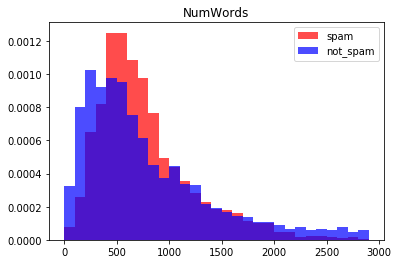

In [90]:
is_spam_data = [doc.features[0]**(1) for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0]**(1) for doc in train_docs if doc[1] == False]
bins = range(0,3000,100)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

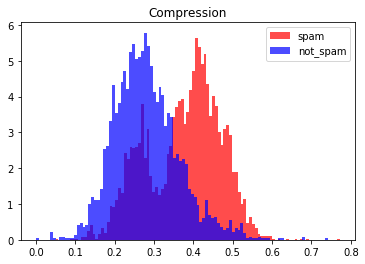

In [91]:
is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('Compression')
plt.legend()
plt.show()

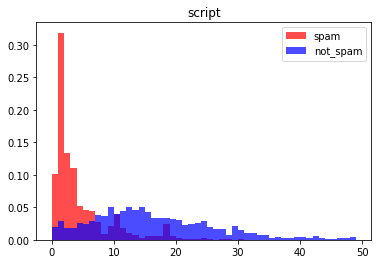

In [92]:
is_spam_data = [doc.features[5] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[5] for doc in train_docs if doc[1] == False]
bins = range(0, 50, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('script')
plt.legend()
plt.show()

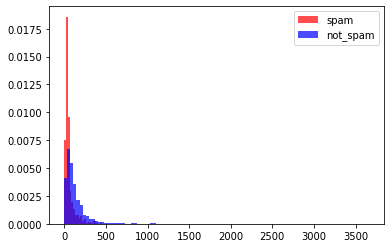

In [93]:
is_spam_data = [doc.features[6] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[6] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
# plt.title('avg-tf-idf')
plt.legend()
plt.show()

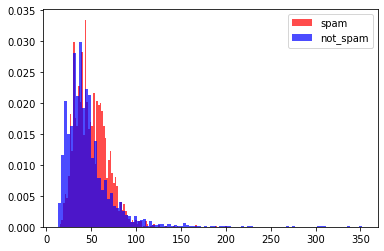

In [94]:
is_spam_data = [doc.features[15] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[15] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
# plt.title('avg-sig-tf-idf')
plt.legend()
plt.show()

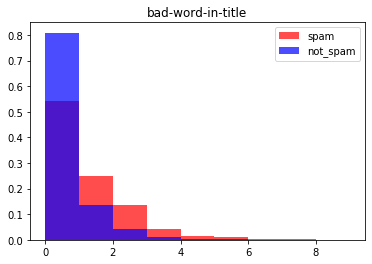

In [95]:
is_spam_data = [doc.features[13] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[13] for doc in train_docs if doc[1] == False]
bins = range(0, 10, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('bad-word-in-title')
plt.legend()
plt.show()

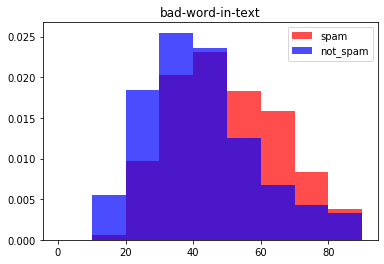

In [96]:
is_spam_data = [doc.features[15] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[15] for doc in train_docs if doc[1] == False]
bins = range(0, 100, 10)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('bad-word-in-text')
plt.legend()
plt.show()

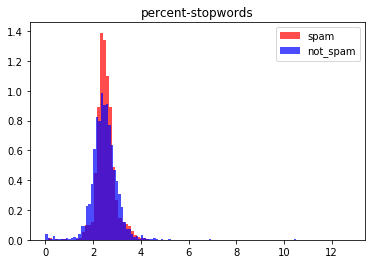

In [97]:
is_spam_data = [doc.features[19] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[19] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
# plt.title('percent-stopwords')
plt.legend()
plt.show()

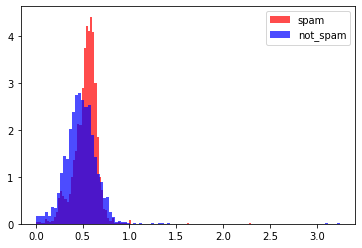

In [110]:
is_spam_data = [doc.features[20] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[20] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('percent-stopwords')
plt.legend()
plt.show()

In [25]:
# not used
from sklearn import tree
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

class Classifier:
    
    def __init__(self, clf=tree.DecisionTreeClassifier()):
        self.clf = clf

    def predict(self, doc):        
        return self.clf.predict(np.array(doc.features).reshape(1, -1))                     
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def train(self, docs):
        X = []
        Y = []
        for doc_num, doc in enumerate(docs):
            X.append(doc.features)
            Y.append(doc.is_spam)
        self.clf = self.clf.fit(X, Y)
        self.X_test = X
        self.Y_test = Y

    def score(self):
        return f1_score(y_pred=self.clf.predict(self.X_test), y_true=self.Y_test, average='macro')

In [20]:
X_train = []
Y_train = []
for doc_num, doc in enumerate(train_docs):
    X_train.append(doc.features)
    Y_train.append(doc.is_spam)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_test = []
Docs_id = []
for doc_num, doc in enumerate(test_docs):
    X_test.append(doc.features)
    Docs_id.append(doc.doc_id)
X_test = np.array(X_test)

In [100]:
average_tf_idf = (np.sum(tf_idf_html, axis=1) / num_features).reshape(-1, 1)
average_significant_tf_idf_ten = (np.sum(np.sort(tf_idf_html, axis=1)[:,-10:], axis=1) / 10).reshape(-1, 1) 
average_significant_tf_idf_twelve = (np.sum(np.sort(tf_idf_html, axis=1)[:,-20:], axis=1) / 20 ).reshape(-1, 1)

In [101]:
X_train = np.concatenate((X_train, 
                          average_tf_idf[:7044], 
                          average_significant_tf_idf_ten[:7044], 
                          average_significant_tf_idf_twelve[:7044]), axis=1)
print(X_train.shape)

X_test = np.concatenate((X_test, 
                         average_tf_idf[7044:23083], 
                         average_significant_tf_idf_ten[7044:23083], 
                         average_significant_tf_idf_twelve[7044:23083]), axis=1)
print(X_test.shape)

(7044, 24)
(16039, 24)


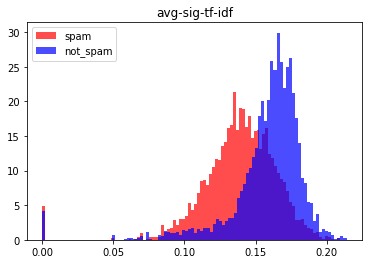

In [108]:
is_spam_data = [X_train[i, 23] for i in range(0, X_train.shape[0]) if Y_train[i] == True]
not_spam_data = [X_train[i, 23] for i in range(0, X_train.shape[0]) if Y_train[i] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('avg-sig-tf-idf')
plt.legend()
plt.show()

In [22]:
X_train = np.concatenate((X_train,  
                          tf_idf_html[:7044], 
                          tf_idf_title[:7044]
                         ), axis=1)
print(X_train.shape)

X_test = np.concatenate((X_test,  
                         tf_idf_html[7044:23083,:], 
                         tf_idf_title[7044:23083,:]
                        ), axis=1)
print(X_test.shape)

(7044, 1501)
(16039, 1501)


In [ ]:
%%time
# param_dist = {'max_depth': sp_randint(1, 50),
#               'n_estimators': sp_randint(100, 1000),
#               'min_samples_leaf': sp_randint(2, 10),
#               "min_samples_split": sp_randint(2, 10),
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]} # RandomForestClassifier

# param_dist = {'n_estimators': sp_randint(1, 1000),
#              'learning_rate': [0.95, 1.0, 1.05]
#              } # Adaboost

# param_dist = {'max_depth': sp_randint(3, 20),
#               'n_estimators': sp_randint(100, 2000),
#               'n_jobs': [6]
#              }  # XGBClassifier

# param_dist = {'hidden_layer_sizes': (10, 3),
#               'learning_rate_init': [0.0001],
# #               'batch_size': sp_randint(32, 500),
# #               'max_iter': sp_randint(100, 500),
#              } # mlp

# param_dist = {"loss" : ["deviance", "exponential"],
#               'learning_rate': [0.1, 0.01, 0.001],
#               'n_estimators': sp_randint(100, 200),
#               "min_samples_split": sp_randint(2, 3),
#               'min_samples_leaf': sp_randint(1, 3),
#               "max_depth": sp_randint(2, 10),

#              } # GradientBoostingClassifier
param_dist = {'C': [10.0, 20.0, 15.0],
              'max_iter': sp_randint(100, 200),
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
             } # LogisticRegression


n_iter_search = 100
clf = LogisticRegression()
search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search, n_jobs=-1, cv=5, scoring='f1', random_state=123)

search.fit(X_train, Y_train)
print(search.best_params_)
print(search.best_score_)
best_model = search.best_estimator_
print(best_model)

In [ ]:
%%time
xgb_model = XGBClassifier(n_estimators=1200, max_deepth=12, n_jobs=-1)
xgb_model.fit(X_train, Y_train)


In [ ]:
y_pred = xgb_model.predict(X_test)

with open('my_submission.csv' , 'w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for i, doc_id in enumerate(Docs_id):
        prediction = 1 if y_pred[i] else 0
        writer.writerow([doc_id, prediction])